In [1]:
#Import Libraries
import numpy as np 
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

#Used to access the STAC catalogs:
from pystac_client import Client

#Used to sign (requesting further access) items form the MPC STAC catalog:
import planetary_computer

#Other libraries for nice outputs:
from IPython.display import Image 

## Access

We use the `Client` function from the `pystac_client` package to access the catalog:

In [3]:
#access catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", 
                      modifier = planetary_computer.sign_inplace)

The `modifier` parameter is needed to access the data in the MPC catalog. 

## Exploration

Let's check out some of the catalog's metadata:

In [4]:
#metadata from the catalog:
print("Title:", catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


We can access the catalog's collections by using the `get_collections()` method:

In [7]:
catalog.get_collections() #this doesn't tell us much

<generator object Client.get_collections at 0x7399c6603230>

Notice the output of `get_collections()` is a **generator**. 

This is a special kind of *lazy* object in Python over which you can loop over like a list. 
Unlike a list, the items in the generator do not exist in memory until you explicitly iterate over them or convert them to a list. 

Let's try getting the collections from the catalog again:

In [13]:
# Get collections and print their names
collections = list(catalog.get_collections())
print('Number of collections:', len(collections))
print('Collections IDs:')
      
for collection in collections:
      print('-', collection.id)
        
# We can see the names of the collections that we just iterated over below:

Number of collections: 122
Collections IDs:
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi
- daymet-monthly-hi
- daymet-monthly-pr
- gnatsgo-tables
- hgb
- cop-dem-glo-30
- cop-dem-glo-90
- goes-cmi
- terraclimate
- nasa-nex-gddp-cmip6
- gpm-imerg-hhr
- gnatsgo-rasters
- 3dep-lidar-hag
- 3dep-lidar-intensity
- 3dep-lidar-pointsourceid
- mtbs
- noaa-c-cap
- 3dep-lidar-copc
- modis-64A1-061
- alos-fnf-mosaic
- 3dep-lidar-returns
- mobi
- landsat-c2-l2
- era5-pds
- chloris-biomass
- kaza-hydroforecast
- planet-nicfi-analytic
- modis-17A2H-061
- modis-11A2-061
- daymet-daily-pr
- 3dep-lidar-dtm-native
- 3dep-lidar-classification
- 3dep-lidar-dtm
- gap
- modis-17A2HGF-061
- planet-nicfi-visual
- gbif
- modis-17A3HGF-061
- modis-09A1-061
- alos-dem
- alos-palsar-mosaic
- deltares-water-availability
- modis-16A3GF-061
- modis-21A2-061
- us-census
- jrc-gsw
- deltares-floods
- modi

## Collection

We can select a single collection for exploration using the `get_child()` method for the catalog and the collection id as the parameter:

In [14]:
naip_collection = catalog.get_child('naip')
naip_collection

id: naip
title: NAIP: National Agriculture Imagery Program
"description: The [National Agriculture Imagery Program](https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/) (NAIP) provides U.S.-wide, high-resolution aerial imagery, with four spectral bands (R, G, B, IR). NAIP is administered by the [Aerial Field Photography Office](https://www.fsa.usda.gov/programs-and-services/aerial-photography/) (AFPO) within the [US Department of Agriculture](https://www.usda.gov/) (USDA). Data are captured at least once every three years for each state. This dataset represents NAIP data from 2010-present, in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format."
"providers: USDA Farm Service Agency (producer, licensor) Esri (processor) Microsoft (host, processor)"
type: Collection
"item_assets: {'image': {'type': 'image/tiff; application=geotiff; profile=cloud-optimized', 'roles': ['data'], 'title': 'RGBIR COG tile', 'eo:bands': [{'name': 'Red', 'common_name': 'red'}, {'name': 'Green', 'common_name': 'green'}, {'name': 'Blue', 'common_name': 'blue'}, {'name': 'NIR', 'common_name': 'nir', 'description': 'near-infrared'}]}, 'metadata': {'type': 'text/plain', 'roles': ['metadata'], 'title': 'FGDC Metdata'}, 'thumbnail': {'type': 'image/jpeg', 'roles': ['thumbnail'], 'title': 'Thumbnail'}}"
msft:region: westeurope
msft:container: naip
msft:storage_account: naipeuwest
"msft:short_description: NAIP provides US-wide, high-resolution aerial imagery. This dataset includes NAIP images from 2010 to the present."
https://stac-extensions.github.io/item-assets/v1.0.0/schema.json


## Catalog Search
We can narrow the search within the `catalog` by specifying a time range, and area of interest, and the collection name. 

The simples way to define the area of interest to look for in the catalog are:
- a GeoJSON-type dictionary with coordinates of the bounding box
- as a list [xmin, ymin, xmax, ymax] with the coordinate values defining the four corners of the bounding box

You could also use a point, or some more complex polygon. 

In this lesson we will look for NAIP scenes over Santa Barbara from 2018 to 2023. We'll use the GeoJSON method to define the area of interest:

In [16]:
#temporal range of interest
time_range = "2018-01-01/2023-01-01"

#NCEAS bounding box (as a GeoJSON)
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-119.70608227128903, 34.426300194372274],
            [-119.70608227128903, 34.42041139020533],
            [-119.6967885126002, 34.42041139020533],
            [-119.6967885126002, 34.426300194372274],
            [-119.70608227128903, 34.426300194372274]
        ]
    ],
}

#Catalog search 
search = catalog.search(
    collections = ['naip'], # a list of collection id
    intersects = bbox,
    datetime = time_range
)

search

To get the items found in the search (or check if there were any matches in the search) we use the `item_collection()` method:

In [17]:
items = search.item_collection()

#Number of items in the search:
len(items)

2

In [ ]:
#Take a look at the items:
items

## Items
Let's get the first item in the search

In [19]:
#get first item in teh catalog search
item = items[0]
type(item)

pystac.item.Item

Remember the STAC item is the cored object in the catalog.

The item does not contain the data itself, but rather the metadata about it and links the access to actual data (assets). 
Some of the metadata:

In [21]:
print('id', item.id)
item.properties

id ca_m_3411935_sw_11_060_20200521


{'gsd': 0.6,
 'datetime': '2020-05-21T00:00:00Z',
 'naip:year': '2020',
 'proj:bbox': [246930.0, 3806808.0, 253260.0, 3814296.0],
 'proj:epsg': 26911,
 'naip:state': 'ca',
 'proj:shape': [12480, 10550],
 'proj:transform': [0.6, 0.0, 246930.0, 0.0, -0.6, 3814296.0, 0.0, 0.0, 1.0]}

Just as the item properties, the item assets are given in a dictionary, with each value being a `pystac.asset`. Let's check the assets in the `item`:

In [22]:
item.assets #the assets are links to the actual data 

{'image': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2020/ca_060cm_2020/34119/m_3411935_sw_11_060_20200521.tif?st=2023-11-26T21%3A20%3A06Z&se=2023-12-04T21%3A20%3A07Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-27T21%3A20%3A05Z&ske=2023-12-04T21%3A20%3A05Z&sks=b&skv=2021-06-08&sig=NEtxfBvrqXrHQD3IKraClK//oXTCKQrqIVkXYiiXGJw%3D>,
 'thumbnail': <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2020/ca_060cm_2020/34119/m_3411935_sw_11_060_20200521.200.jpg?st=2023-11-26T21%3A20%3A06Z&se=2023-12-04T21%3A20%3A07Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-27T21%3A20%3A05Z&ske=2023-12-04T21%3A20%3A05Z&sks=b&skv=2021-06-08&sig=NEtxfBvrqXrHQD3IKraClK//oXTCKQrqIVkXYiiXGJw%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3411

In [24]:
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)
    
#for every key in the assets, print the key name and access the title of the assets

image -- RGBIR COG tile
thumbnail -- Thumbnail
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [26]:
item.assets.keys() #these are the keys from our assets dictionary

dict_keys(['image', 'thumbnail', 'tilejson', 'rendered_preview'])

Notice each asset has an `href`, which is a link to the asset object(ie. the data). 
For example, we can use the URL for the rendered preview asset to plot it:

In [30]:
Image(url=item.assets['rendered_preview'].href, width = 500) #retrieving image and showing the output

## Load Data

The raster data in our current `item` is in the `image` asset. Again, we access this data via its URL. 

This time we open it using `rioxr.open_rasterio()` directly:

In [32]:
sb = rioxr.open_rasterio(item.assets['image'].href)
sb

<xarray.DataArray (band: 4, y: 12480, x: 10550)>
[526656000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.469e+05 2.469e+05 ... 2.533e+05 2.533e+05
  * y            (y) float64 3.814e+06 3.814e+06 ... 3.807e+06 3.807e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

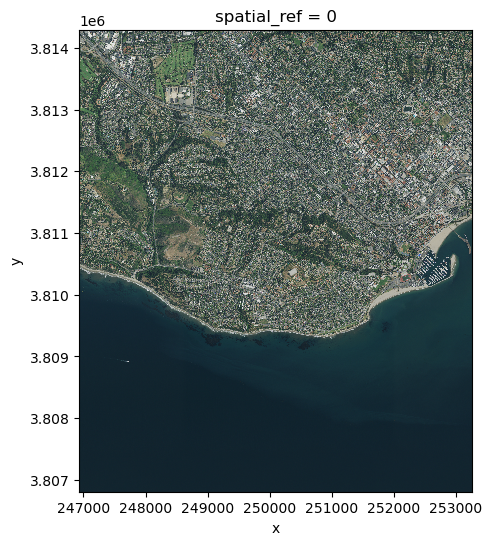

In [33]:
# Plot raster with correct ratio

size = 6 #height in of plot 
aspect = sb.rio.width/sb.rio.height
sb.sel(band=[1,2,3]).plot.imshow(size=size, aspect=aspect)

## Exercise

The `cop-dem-glo-90` (id of collection) collection contains the Copernicus DEM at 90m resolution (the one we used for the Grand Canyon). 

1. Use the bbox for Santa Barbara to look for items in this collection
2. Get the first item in the search and check its assets
3. Plot the item's rendered preview asset
4. Open the item's data using rioxarray

In [36]:
#Use the bbox for Santa Barbara for items in collection: cop-demo-glo90
search2 = catalog.search(
    collections = ['cop-dem-glo-90'], # a list of collection id
    intersects = bbox,
    datetime = time_range
)

items2 = search2.item_collection()

#Number of items in the search:
len(items2)

items2

id: Copernicus_DSM_COG_30_N34_00_W120_00_DEM
"bbox: [-120.00041666666667, 34.000416666666666, -119.00041666666667, 35.000416666666666]"
gsd: 90
datetime: 2021-04-22T00:00:00Z
platform: TanDEM-X
proj:epsg: 4326
"proj:shape: [1200, 1200]"
"proj:transform: [0.0008333333333333334, 0.0, -120.00041666666667, 0.0, -0.0008333333333333334, 35.000416666666666]"
https://stac-extensions.github.io/projection/v1.0.0/schema.json
href: https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP90_hh/Copernicus_DSM_COG_30_N34_00_W120_00_DEM.tif?st=2023-11-26T21%3A39%3A40Z&se=2023-12-04T21%3A39%3A42Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-27T21%3A39%3A39Z&ske=2023-12-04T21%3A39%3A39Z&sks=b&skv=2021-06-08&sig=qt4yGbZ/9krZE9KfP0/RWBPymTc8UKhAficlBHi%2B95g%3D
type: image/tiff; application=geotiff; profile=cloud-optimized


In [39]:
#2. Get the first item in the search and check its assets
item2 = items2[0]
item2.assets #viewing the assets for this item

{'data': <Asset href=https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP90_hh/Copernicus_DSM_COG_30_N34_00_W120_00_DEM.tif?st=2023-11-26T21%3A39%3A40Z&se=2023-12-04T21%3A39%3A42Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-27T21%3A39%3A39Z&ske=2023-12-04T21%3A39%3A39Z&sks=b&skv=2021-06-08&sig=qt4yGbZ/9krZE9KfP0/RWBPymTc8UKhAficlBHi%2B95g%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=cop-dem-glo-90&item=Copernicus_DSM_COG_30_N34_00_W120_00_DEM&assets=data&colormap_name=terrain&rescale=-1000%2C4000&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=cop-dem-glo-90&item=Copernicus_DSM_COG_30_N34_00_W120_00_DEM&assets=data&colormap_name=terrain&rescale=-1000%2C4000&format=png>}

In [48]:
#3. Plot the item's rendered preview asset
Image(url=item2.assets['rendered_preview'].href, width = 500) #retrieving image and showing the output
sb2 = rioxr.open_rasterio(item2.assets['data'].href)
sb2

<xarray.DataArray (band: 1, y: 1200, x: 1200)>
[1440000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -120.0 -120.0 -120.0 ... -119.0 -119.0 -119.0
  * y            (y) float64 35.0 35.0 35.0 35.0 35.0 ... 34.0 34.0 34.0 34.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

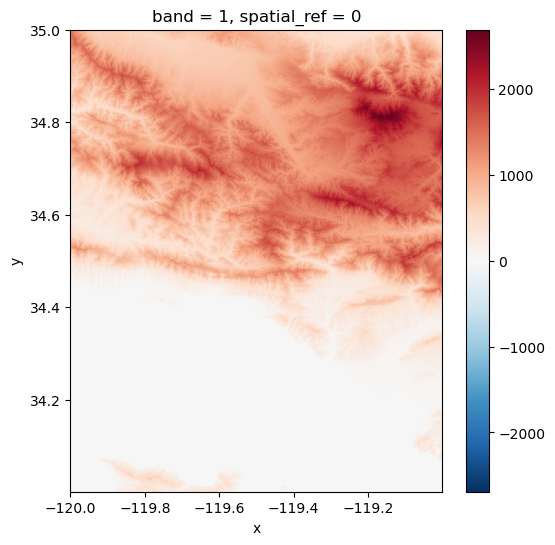

In [49]:
#3. Plot the item's rendered preview asset
size = 6 #height in of plot 
aspect = sb2.rio.width/sb2.rio.height
sb2.sel(band=1).plot.imshow(size=size, aspect=aspect)